# Effect of Morning and Afternoon Classes on Grades
Alexander Bailey, Kayli Leung

## Question

Is there a statistically significant difference in the percentage of A's given if a class starts before noon or after noon?

## Hypotheses

*H<sub>0</sub>*: There is no significant difference in the mean percentage of A's in the morning classes and afternoon classes.

$\mu$<sub>AM</sub> = $\mu$<sub>PM</sub>

*H<sub>A</sub>*: There is a significant difference in the mean percentage of A's in the morning and afternoon classes.

$\mu$<sub>AM</sub> $\neq$ $\mu$<sub>PM</sub>

## Methodology
We select an *alpha* value of 0.05.

We will perform a two-tail, two-sample t-test on the data. If we find significance. We will perform a one-tail, two-sample t-test to look at directionality.

Class start and end times are listed in minutes from midnight.

### Import Necessary Libraries

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy.stats as stats
from simulations import get_sample_size, clean_df
import random

random.seed(2)

# Data Preparation

## Connect to UW- Madison PostgreSQL database

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

We are interested in the percentage of A's given in a specific course and section. While there are other grades such as "credit" and "incomplete", these grades are not given a GPA value and we will therefore ignore them and only use A-F grades. We also want to collect the start times of the classes. Finally, we want the section type as we want to make sure that we measure Lecture and Seminar classes as opposed to Independent/Field Studies and Labs/Discussions (which often contribute to a lecture class' grade).

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [4]:
cur.execute(group_and_as)
grades_df = pd.DataFrame(cur.fetchall())
grades_df.columns = [i[0] for i in cur.description]
grades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217399 entries, 0 to 217398
Data columns (total 11 columns):
a_count                 217399 non-null int64
ab_count                217399 non-null int64
b_count                 217399 non-null int64
bc_count                217399 non-null int64
c_count                 217399 non-null int64
d_count                 217399 non-null int64
f_count                 217399 non-null int64
start_time              217399 non-null int64
section_type            217399 non-null object
course_offering_uuid    217399 non-null object
section_number          217399 non-null int64
dtypes: int64(9), object(2)
memory usage: 18.2+ MB


Our initial table has 217,339 classes.

In [5]:
grades_df = clean_df(grades_df)
grades_df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
4,6,0,0,0,0,0,0,725,LEC,bebb6ce8-a2c9-3e22-84c7-1a67781f90f0,1,6
5,6,0,0,0,0,0,0,1050,LEC,bebb6ce8-a2c9-3e22-84c7-1a67781f90f0,1,6
23,16,44,33,4,5,0,0,800,LEC,a7e2605c-df99-31e1-86c5-05f4f6d3d463,1,102
24,11,1,0,0,0,0,0,800,LEC,bbe66764-b560-3fe2-b35a-195eb60e6112,39,12
25,8,4,1,0,0,0,0,660,LEC,bbe66764-b560-3fe2-b35a-195eb60e6112,24,13


In [6]:
#grades_df.to_pickle("grades.pkl")
grades_df = pd.read_pickle("grades.pkl")

In [7]:
grades_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70987 entries, 35 to 217398
Data columns (total 13 columns):
a_count                 70987 non-null int64
ab_count                70987 non-null int64
b_count                 70987 non-null int64
bc_count                70987 non-null int64
c_count                 70987 non-null int64
d_count                 70987 non-null int64
f_count                 70987 non-null int64
start_time              70987 non-null int64
section_type            70987 non-null object
course_offering_uuid    70987 non-null object
section_number          70987 non-null int64
total_count             70987 non-null int64
ratio_of_as             70987 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 7.6+ MB


After removing non-lecture/seminar classes and classes with zero students, there are 88,368 classes.

In [8]:
grades_df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count,ratio_of_as
207200,8,3,0,0,0,0,0,360,LEC,21f65d93-7934-3be3-868f-b3c00dc972c2,14,11,0.727273
63242,11,0,0,0,0,0,0,360,LEC,4535dafb-c7f7-3d0b-a161-88ef94c62533,5,11,1.000000
108652,87,44,16,4,1,0,0,360,LEC,eae1b18d-16a9-3030-b3b1-692b9615b506,1,152,0.572368
63241,9,0,0,0,0,0,0,360,LEC,72aebace-1440-3bbd-882b-4ea9eae3769f,15,9,1.000000
108651,86,53,17,6,0,0,0,360,LEC,067ba4da-bd95-394b-9bd7-104d9020c7c7,1,162,0.530864


We will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input. 

In [9]:
grades_df = grades_df[grades_df['start_time'] >= 360]
grades_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70987 entries, 35 to 217398
Data columns (total 13 columns):
a_count                 70987 non-null int64
ab_count                70987 non-null int64
b_count                 70987 non-null int64
bc_count                70987 non-null int64
c_count                 70987 non-null int64
d_count                 70987 non-null int64
f_count                 70987 non-null int64
start_time              70987 non-null int64
section_type            70987 non-null object
course_offering_uuid    70987 non-null object
section_number          70987 non-null int64
total_count             70987 non-null int64
ratio_of_as             70987 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 7.6+ MB


We now have 85,173 classes.

Create a column for the ratio of A's.

In [10]:
ratio_column = np.array(grades_df['a_count'] / grades_df['total_count'])

In [11]:
grades_df['ratio_of_as'] = ratio_column

In [12]:
grades_df.drop_duplicates(inplace=True)
grades_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70987 entries, 35 to 217398
Data columns (total 13 columns):
a_count                 70987 non-null int64
ab_count                70987 non-null int64
b_count                 70987 non-null int64
bc_count                70987 non-null int64
c_count                 70987 non-null int64
d_count                 70987 non-null int64
f_count                 70987 non-null int64
start_time              70987 non-null int64
section_type            70987 non-null object
course_offering_uuid    70987 non-null object
section_number          70987 non-null int64
total_count             70987 non-null int64
ratio_of_as             70987 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 7.6+ MB


Dropping any potential duplicates reduces classes to 70,987

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


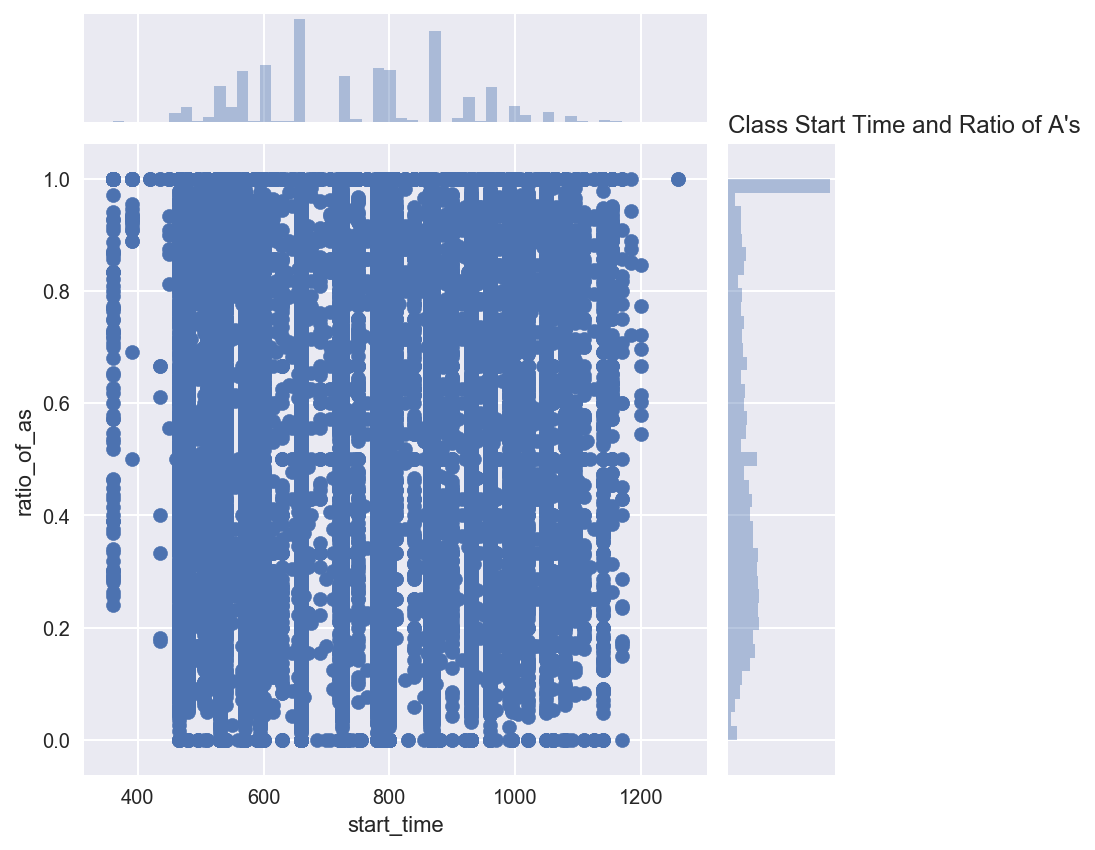

In [13]:
sns.jointplot('start_time', 'ratio_of_as',grades_df);
plt.title("Class Start Time and Ratio of A's", loc='left')
plt.show()

The start times of classes appear to be very spread. Whereas there is much more classes that give a high proportion of A's to lower proportions of A's.

Create separate dataframes for AM and PM classes.

In [14]:
morning = grades_df.loc[grades_df['start_time'] < 720, 'ratio_of_as']
afternoon = grades_df.loc[grades_df['start_time'] >= 720, 'ratio_of_as']

In [15]:
len(morning)

31901

In [16]:
len(afternoon)

39086

There are 31,901 morning classes and 39,086 afternoon classes.

## Testing

### Determine Sample Size

In [17]:
moe = 0.1
z = 1.96 # z value for alpha 0.05

vars_and_ns = {'morn': (np.var(morning), len(morning)), 
               'after': (np.var(afternoon), len(afternoon))}

n = get_sample_size(moe, z, vars_and_ns)

In [18]:
n

66

We will use samples from morning and afternoon of size 66.

In [19]:
morning_sample = random.sample(list(morning), k=n)
afternoon_sample = random.sample(list(afternoon), k=n)


In [20]:
t, p = stats.ttest_ind(morning_sample, afternoon_sample)
print("pvalue: " + str(round(p, 4)))

pvalue: 0.1643


## Evaluation
Our p-value is greater than our halved-*alpha* of 0.025 (since a two-tailed test). This means that we cannot reject the null hypothesis. We cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 

If we want to improve our schedules to increase the percentage of A's we will need to look at other factors.